In [1]:
import sqlite3
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# db files
disk_db_file = "./sample_data/disk/database.db"
colmap_sift_db_file = "./sample_data/colmap/database.db"

In [3]:
# connection 
disk_conn = sqlite3.connect(disk_db_file)
colmap_sift_conn = sqlite3.connect(colmap_sift_db_file)

# cursor
disk_cursor = disk_conn.cursor()
colmap_sift_cursor = colmap_sift_conn.cursor()


In [4]:
MAX_IMAGE_ID = 2**31 - 1

def pair_id_to_image_ids(pair_id):
    image_id2 = pair_id % MAX_IMAGE_ID
    image_id1 = (pair_id - image_id2) / MAX_IMAGE_ID
    return image_id1, image_id2

In [5]:
# function to print all the tables 
def print_tables(cursor):
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    print([table[0] for table in cursor.fetchall()])

# print tables
print_tables(disk_cursor)
print_tables(colmap_sift_cursor)

['cameras', 'sqlite_sequence', 'images', 'keypoints', 'descriptors', 'matches', 'two_view_geometries']
['cameras', 'sqlite_sequence', 'images', 'keypoints', 'descriptors', 'matches', 'two_view_geometries']


In [6]:
# function to get image ids to image names
def get_image_ids_to_image_names(cursor):
    cursor.execute("SELECT image_id, name FROM images;")
    image_ids_to_image_names = {}
    for row in cursor.fetchall():
        image_ids_to_image_names[row[0]] = row[1]
    return image_ids_to_image_names

# get image ids to image names
image_ids_to_image_names = get_image_ids_to_image_names(disk_cursor)


In [7]:
def blob_to_array(blob, dtype, shape=(-1,)):
    if blob is None:
        return []

    return np.fromstring(blob, dtype=dtype).reshape(*shape)

/tmp/ipykernel_22457/814951339.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(blob, dtype=dtype).reshape(*shape)


0.jpg
(11732, 2)
(9894, 2)


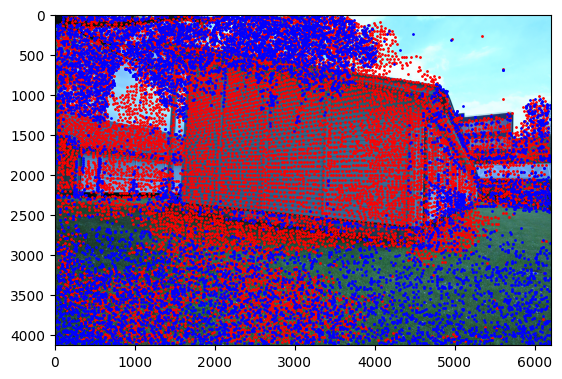

In [12]:
# function to get keypoints
def get_keypoints(cursor,method:str):
    # preprocess keypoints
    if method=='disk':
        keypoints = dict(
            (image_id, blob_to_array(data, np.float32, (-1, 2)))
            for image_id, data in cursor.execute("SELECT image_id, data FROM keypoints")
        )
    elif method=='colmap':
        keypoints = dict(
            (image_id, blob_to_array(data, np.float32, (-1, 6)))
            for image_id, data in cursor.execute("SELECT image_id, data FROM keypoints")
        )
    return keypoints

# disk keypoints
disk_keypoints = get_keypoints(disk_cursor,method='disk')
colmap_keypoints = get_keypoints(colmap_sift_cursor,method='colmap')


# visualize keypoints

image_id = 1

# read image
image_name = image_ids_to_image_names[image_id]
print(image_name)
image = cv2.imread(f"./sample_data/preprocessed_images/{image_name}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# draw keypoints
disk_img_keypoints = disk_keypoints[image_id]
colmap_img_keypoints = colmap_keypoints[image_id][:, :2]

# draw keypoints
plt.figure()
plt.imshow(image)
plt.scatter(disk_img_keypoints[:, 0], disk_img_keypoints[:, 1], c='r', s=1)
plt.scatter(colmap_img_keypoints[:, 0], colmap_img_keypoints[:, 1], c='b', s=1)


print(disk_img_keypoints.shape)
print(colmap_img_keypoints.shape)

In [13]:
# matches
def get_matches(cursor):
    matches = dict(
        (pair_id, blob_to_array(data, np.uint32, (-1, 2)))
        for pair_id, data in cursor.execute("SELECT pair_id, data FROM matches")
    )
    return matches

# disk matches
disk_matches = get_matches(disk_cursor)
colmap_matches = get_matches(colmap_sift_cursor)

/tmp/ipykernel_22457/814951339.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(blob, dtype=dtype).reshape(*shape)


In [14]:
disk_matches.keys()==colmap_matches.keys()

False

In [15]:
colmap_keypoints[1][0]

array([1758.8395   ,    4.823415 ,   -3.4539564,   -3.7100534,
          3.7085764,   -3.455332 ], dtype=float32)

In [16]:
import numpy as np


def convert_to_sift_params(values):
    # Unpacking the values
    (
        x,
        y,
        a11,
        a12,
        a21,
        a22,
    ) = values

    # Calculate scale as the geometric mean of the Euclidean norms of the matrix columns
    scale_x = np.sqrt(a11**2 + a21**2)
    scale_y = np.sqrt(a12**2 + a22**2)
    scale = (scale_x + scale_y) / 2

    # Calculate orientation from the first column of the affine matrix
    orientation = np.arctan2(a21, a11)

    # Convert orientation to degrees (optional, if needed for interpretation)

    return x, y, scale, orientation


# Values as given
values = [
    3.0667712e03,
    5.9550467e00,
    -3.2951796e00,
    -1.6485132e-01,
    1.6489282e-01,
    -3.2943501e00,
]

# Convert and print the results
x, y, scale, orientation = convert_to_sift_params(values)
print(f"x: {x}, y: {y}, scale: {scale}, orientation: {orientation} degrees")

x: 3066.7712, y: 5.9550467, scale: 3.2988874209741694, orientation: 3.0915937423330107 degrees
